In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Arc

In [53]:
a = np.random.randn(100)

In [56]:
list(zip((111.0, 517.276)))

[(111.0,), (517.276,)]

In [ ]:

get_R = {
    (0, 3)      : 0.2,
    (3, 6)      : 0.4,
    (6, 10)     : 0.6,
    (10, 18)    : 0.8,
    (18, 30)    : 1.0,
    (30, 50)    : 1.6,
    (50, 80)    : 2.0,
    (80, 120)   : 2.5,
    (120, 180)  : 3.0,
    (180, 250)  : 4.0,
    (250, 320)  : 5.0,
    (320, 400)  : 6.0,
    (400, 500)  : 8.0,
    (500, 630)  : 10,
    (630, 800)  : 12,
    (800, 1000) : 16,
    (1000, 1250): 20,
    (1250, 1600): 25,
}


class Shaft:
    def __init__(self, initial_diameter=20.0, length=200.):
        self.initial_diameter = initial_diameter
        self.length = length
        self.steps = []          # [(位置, 直径)]
        self.shoulders = []      # [(位置, 高度, 宽度)]
        self.keyways = []        # [(位置, 长度, 宽度)]
        self.gears = []          # [(位置, 宽度, 直径)]
        
        self.chamfer_radius = 0  # 圆角半径
        for k, v in get_R.items():
            if initial_diameter <= k[1] and initial_diameter > k[0]:
                self.chamfer_radius = v
                break
        
        self.contour = []        # 原始轮廓
        self.chamfered_contour = []  # 倒角处理后的轮廓
        
        self.forces = {'y': [], 'z': []}    # 受力
        self.bends  = {'y': [], 'z': []}    # 受弯矩
        self.twists = []                    # 受转矩

    def add_force(self, pos, val_y=+0., val_z=+0.):
        '''
        添加受力
        
        Args:
            pos: float
                位置
            val_y: float
                y方向数量（正方向向下）
            val_z: float
                z方向数量（正方向向下）
        '''
        if val_y != 0:
            self.forces['y'].append((pos, val_y))
        if val_z != 0:
            self.forces['z'].append((pos, val_z))
        
    def add_bend(self, pos, val_y=+0., val_z=+0.):
        '''
        添加弯矩
        
        Args:
            pos: float
                位置
            val_y: float
                y方向数量（正方向为逆时针）
            val_z: float
                z方向数量（正方向为逆时针）
        '''
        if val_y != 0:
            self.bends['y'].append((pos, val_y))
        if val_z != 0:
            self.bends['z'].append((pos, val_z))
            
    def add_twist(self, pos, val):
        '''
        添加扭矩
        
        Args:
            pos: float
                位置
            val: float
                数量
        '''
        self.twists.append((pos, val))

    def add_step(self, position, diameter):
        self.steps.append((position, diameter))

    def add_shoulder(self, position, height, width):
        self.shoulders.append((position, height, width))

    def add_keyway(self, position, length, width):
        self.keyways.append((position, length, width))

    def add_gear(self, position, width, diameter, fr, ft, fa):
        self.gears.append((position, width, diameter))
        self.add_force(position, ft, fr)
        self.add_bend(position, 0, fa * diameter / 2e-3)
        self.add_twist(position, ft * diameter / 2e-3)

    def _get_diameter_at(self, pos, events):
        """核心方法：获取指定位置的直径"""
        # 按位置排序事件
        sorted_events = sorted(events, key=lambda x: x[0])
        current_diam = self.initial_diameter
        
        for event_pos, event_diam in sorted_events:
            if event_pos <= pos:
                current_diam = event_diam
            else:
                break  # 已过目标位置，提前终止
        return current_diam

    def process_features(self):
        events = []
        events.append((0, self.initial_diameter))
        
        # 处理阶梯特征
        for pos, diam in self.steps:
            events.append((pos, diam))
        
        # 转换轴肩特征
        for pos, height, width in self.shoulders:
            current_diam = self._get_diameter_at(pos, events)
            events.append((pos, current_diam + height))
            events.append((pos + width, current_diam))
        
        # 合并事件点
        events.sort(key=lambda x: x[0])
        merged = []
        last_pos = -np.inf
        for pos, diam in events:
            if pos > last_pos:
                merged.append((pos, diam))
                last_pos = pos
            else:
                merged[-1] = (pos, diam)
        
        # 生成基础轮廓
        self.contour = []
        current_diam = self.initial_diameter
        current_pos = 0
        self.contour.append((current_pos, current_diam))
        
        for pos, diam in merged:
            if pos <= current_pos:
                continue
            self.contour.extend([(pos, current_diam), (pos, diam)])
            current_diam = diam
            current_pos = pos
        
        # 末端延伸
        self.contour.append((self.length, current_diam))
        
        # 圆角处理
        self._apply_chamfers()

    def _apply_chamfers(self):
        """双圆角处理逻辑"""
        self.chamfered_contour = []
        
        for i in range(len(self.contour)-1):
            x0, d0 = self.contour[i]
            x1, d1 = self.contour[i+1]
            
            if x0 == x1:  # 垂直段（直径变化点）
                # 转换为半径单位进行计算
                r0 = d0 / 2
                r1 = d1 / 2
                delta_r = r1 - r0
                abs_radius = abs(self.chamfer_radius)
                
                # 内圆角（外侧）
                outer_cx = x0 + np.sign(delta_r) * abs_radius
                outer_cy = max(r0, r1) - abs_radius
                if delta_r > 0:
                    outer_theta = np.linspace(np.pi, np.pi / 2, 20)
                else:
                    outer_theta = np.linspace(np.pi / 2, 0, 20)
                
                # 外圆角（内侧）
                inner_cx = x0 - np.sign(delta_r) * abs_radius
                inner_cy = min(r0, r1) + abs_radius
                if delta_r > 0:
                    inner_theta = np.linspace(-np.pi / 2, 0, 20)
                else:
                    inner_theta = np.linspace(-np.pi, -np.pi / 2, 20)
                
                # 生成外圆角坐标（直径单位）
                outer_x = outer_cx + abs_radius * np.cos(outer_theta)
                outer_y = (outer_cy + abs_radius * np.sin(outer_theta)) * 2
                
                # 生成内圆角坐标（直径单位）
                inner_x = inner_cx + abs_radius * np.cos(inner_theta)
                inner_y = (inner_cy + abs_radius * np.sin(inner_theta)) * 2
                
                self.contour[i+1] = (x1 + abs_radius, d1)
                
                # 合并并排序坐标点
                if delta_r > 0:
                    combined = sorted(zip(inner_x, inner_y), key=lambda p: p[0])
                    combined += sorted(zip(outer_x, outer_y), key=lambda p: p[0])
                else:
                    combined = sorted(zip(outer_x, outer_y), key=lambda p: p[0])
                    combined += sorted(zip(inner_x, inner_y), key=lambda p: p[0])
                self.chamfered_contour.extend(combined)
            else:  # 水平段
                self.chamfered_contour.append((x0, d0))

        # 添加轮廓末端
        self.chamfered_contour.append(self.contour[-1])
        
    def _get_diameter_at_process(self, pos):
        """处理后的直径查询"""
        for i in range(len(self.contour)-1):
            x0, d0 = self.contour[i]
            x1, d1 = self.contour[i+1]
            if x0 <= pos <= x1:
                return d0
        return self.contour[-1][1]
    
    def get_sampled_diameters(self, n=5000):
        """
        返回从整个轴体均匀采样的n个点的直径
        """
        # 确定轴体的总长度
        total_length = self.contour[-1][0]
        # 计算采样间隔
        interval = total_length / (n - 1)
        # 初始化采样点直径列表
        sampled_diameters = []
        # 进行采样
        for i in range(n):
            pos = i * interval
            # 获取该位置的直径
            diam = self._get_diameter_at_process(pos)
            sampled_diameters.append(diam)
        return sampled_diameters

    def get_sampled_pos(self, n=5000):
        return np.linspace(0, self.length, n)

    def calculate_W(self, n=5000):
        """
        计算轴的截面模量
        """
        pos = np.linspace(0, self.length, n)
        # 检查是否含有键槽，初始化为-1
        keyway_index = np.full(n, -1)
        for i, (pos, length, width) in enumerate(self.keyways):
            keyway_index[pos <= pos < pos + length] = i
        # 获取采样直径
        diameters = self.get_sampled_diameters(n)
        # 计算截面模量
        W = np.zeros(n)
        W[keyway_index == -1] = np.pi * diameters[keyway_index == -1]**3 / 32
        
        # 创建b值和h值的列表
        b_values = [2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 18, 20, 22]
        h_values = [1.986, 2.986, 3.982, 4.982, 5.982, 6.91, 7.91, 7.91, 8.91, 9.91, 10.89, 11.89, 13.89]
        # 标准平键尺寸
        b_h_dict = {b: h for b, h in zip(b_values, h_values)}
        
        for i, (pos, length, width) in enumerate(self.keyways):
            d = diameters[keyway_index == i]
            depth = b_h_dict[width] / 2 + 0.005 # 计算键槽深度
            W[keyway_index == i] = np.pi * d**3 / 32 - \
                width * depth * (d - depth)**2 / 2 / d
        return diameters, W

    def plot(self):
        if not self.chamfered_contour:
            self.process_features()
        
        fig, ax = plt.subplots(figsize=(10, 4))
        ax.set_aspect('equal')
        
        # 处理倒角轮廓数据
        x = [p[0] for p in self.chamfered_contour]
        y = [p[1]/2 for p in self.chamfered_contour]  # 转换为半径
        
        # 绘制轮廓
        ax.plot(x, y, 'b-', lw=1.2, label='Shaft')
        ax.plot(x, [-v for v in y], 'b-', lw=1.2)
        ax.fill_between(x, y, [-v for v in y], color='skyblue', alpha=0.4)
        
        # 绘制受力
        for pos, val in self.forces['y']:
            draw_dir = (1 if val < 0 else -1) * 5
            ax.arrow(pos, 0, draw_dir, draw_dir, head_width=2, head_length=4, fc='r', ec='r')
        for pos, val in self.forces['z']:
            draw_dir = (1 if val < 0 else -1) * 10
            ax.arrow(pos, 0, 0, draw_dir, head_width=2, head_length=4, fc='r', ec='r')
            
        # 绘制弯矩
        for pos, val in self.bends['y']:
            draw_dir = (1 if val < 0 else -1) * np.pi / 2
            body = Arc((pos, 0), 10, 10, theta1=0, theta2=draw_dir, edgecolor='r', lw=2)
            ax.add_patch(body)
        for pos, val in self.bends['z']:
            draw_dir = (1 if val < 0 else -1) * np.pi / 2
            body = Arc((pos, 0), 10, 10, theta1=90, theta2=90+draw_dir, edgecolor='r', lw=2)
            ax.add_patch(body)
        
        # 绘制半圆形键槽
        for pos, length, width in self.keyways:
            # 绘制上侧线段
            ax.plot([pos, pos + length], [width / 2, width / 2], 'r-', lw=2)
            # 绘制下侧线段
            ax.plot([pos, pos + length], [-width / 2, -width / 2], 'r-', lw=2)
            
            # 绘制左侧半圆
            left_arc = Arc((pos, 0), width, width, theta1=90, theta2=270, edgecolor='red', lw=2)
            ax.add_patch(left_arc)
            
            # 绘制右侧半圆
            right_arc = Arc((pos + length, 0), width, width, theta1=-90, theta2=90, edgecolor='red', lw=2)
            ax.add_patch(right_arc)
        
        # 绘制齿轮
        for pos, width, diameter in self.gears:
            gear = Rectangle((pos, -diameter/2), width, diameter, fc='orange', alpha=0.5)
            ax.add_patch(gear)
        
        plt.title("Improved Shaft Visualization")
        plt.xlabel("Axial Position (mm)")
        plt.ylabel("Radial Dimension (mm)")
        plt.grid(True)
        return fig


In [49]:
shaft = Shaft(initial_diameter=25)
shaft.add_step(30, 60)    # 直径增大
shaft.add_step(50, 40)    # 直径减小
shaft.add_shoulder(70, 50, 20)
shaft.add_keyway(40, 15, 3)
shaft.add_gear(100, 20, 65, 100, 100, 100)
shaft.process_features()

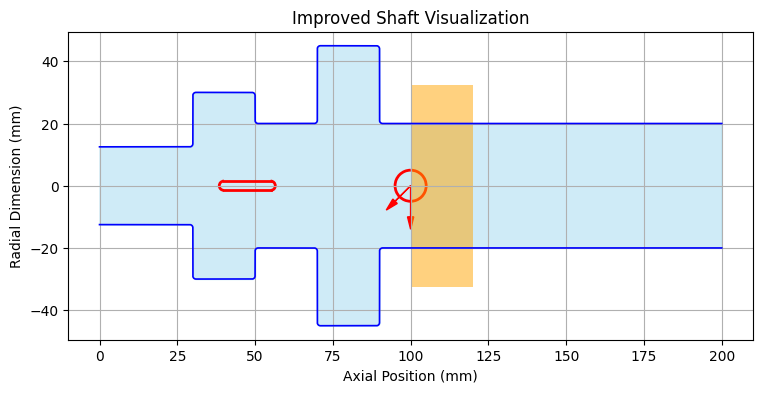

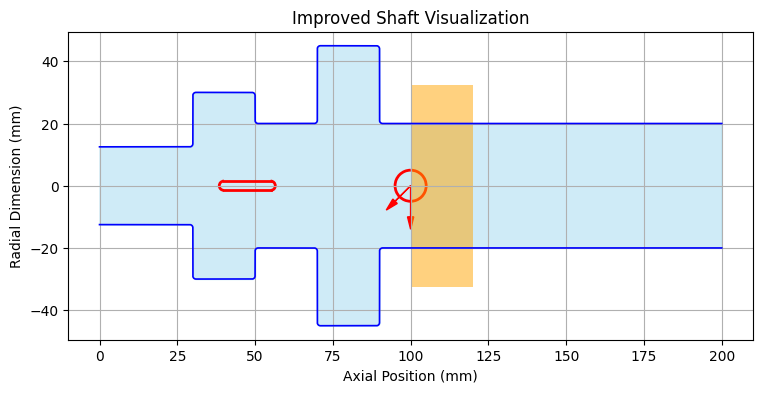

In [50]:
shaft.plot()